In [61]:
!pip install pydotplus

In [102]:
!pip install graphviz

In [ ]:
#for windows
#conda install -c anaconda graphviz python-graphviz 

In [ ]:
#for macbook m1 users
brew install graphviz 

<h1><center>Loading modules</center></h1>

In [344]:
# General modules
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import seaborn as sns
import math
%matplotlib inline

In [345]:
#warning modules
import warnings
warnings.filterwarnings("ignore")

In [346]:
# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from six import StringIO

<h1><center>Loading Dataset</center></h1>

<h1>About The Data</h1>

1. The dataset was uploaded to Kaggle in 06/2020 by Yamaç Eren Ay, who used the Spotify Web API for develepors to build a data that contains more than 160,000 songs. These are NOT all the spotify tracks, but quite alot of it...
2. The task in this dataset is to predict the popularity of the track according to the track's features.
3. Each row in the data represent a unique track, identified by a unique ID feature generated by Spotify.

In [347]:
data_df = pd.read_csv('data/data_o.csv')
data_df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

In [348]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

<h1><center>Cleaning</center></h1>

<h1>Features Selection</h1>

Looking closely at the features, there are some features to consider whether to include in the final model or not:

1. **id**: id is unique for each track, therfore cannot assist a model and will be dropped.
2. **name**: There are 132,940 unique values. In our opinion, this is a problematic categorical feature to insert in a model, and will be dropped.
3. **artists**: there are 33,375 unique features. Since we enticipate the artist will influence the popularity of the track, this feature will remain and be handled seperatley.
4. **release_date \ year**: The year feature is a derivative to the release_date feature, therfore one of them should be excluded. Since the release date contains rows with full date and others with year only, the release_date will be dropped.

In [349]:
columns = ['id', 'name', 'artists', 'release_date', 'year']
for col in columns:
    print(f'{col:<15}: {data_df[col].nunique()} unique values')

id             : 170653 unique values
name           : 133638 unique values
artists        : 34088 unique values
release_date   : 11244 unique values
year           : 100 unique values


In [350]:
df = data_df.drop(labels=['id', 'name', 'release_date'], axis=1)
df.shape

(170653, 16)

<h1>Duplicates & Nulls</h1>

Prior to the feature dropped above, there were not any duplicates in the data set, due to the unique id feature.

After the a.m. features removal, there are 669 duplicates in the dataset.

Only the first copy of the duplicate will remain for the model.

There are not null values in the data set.

In [351]:
df.duplicated().sum()

628

In [352]:
df = df[~df.duplicated()==1]
df.shape

(170025, 16)

In [353]:
df.isnull().sum().sum()

0

<h1><center>EDA</center></h1>

In [354]:
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 15 numeric columns & 1 string columns


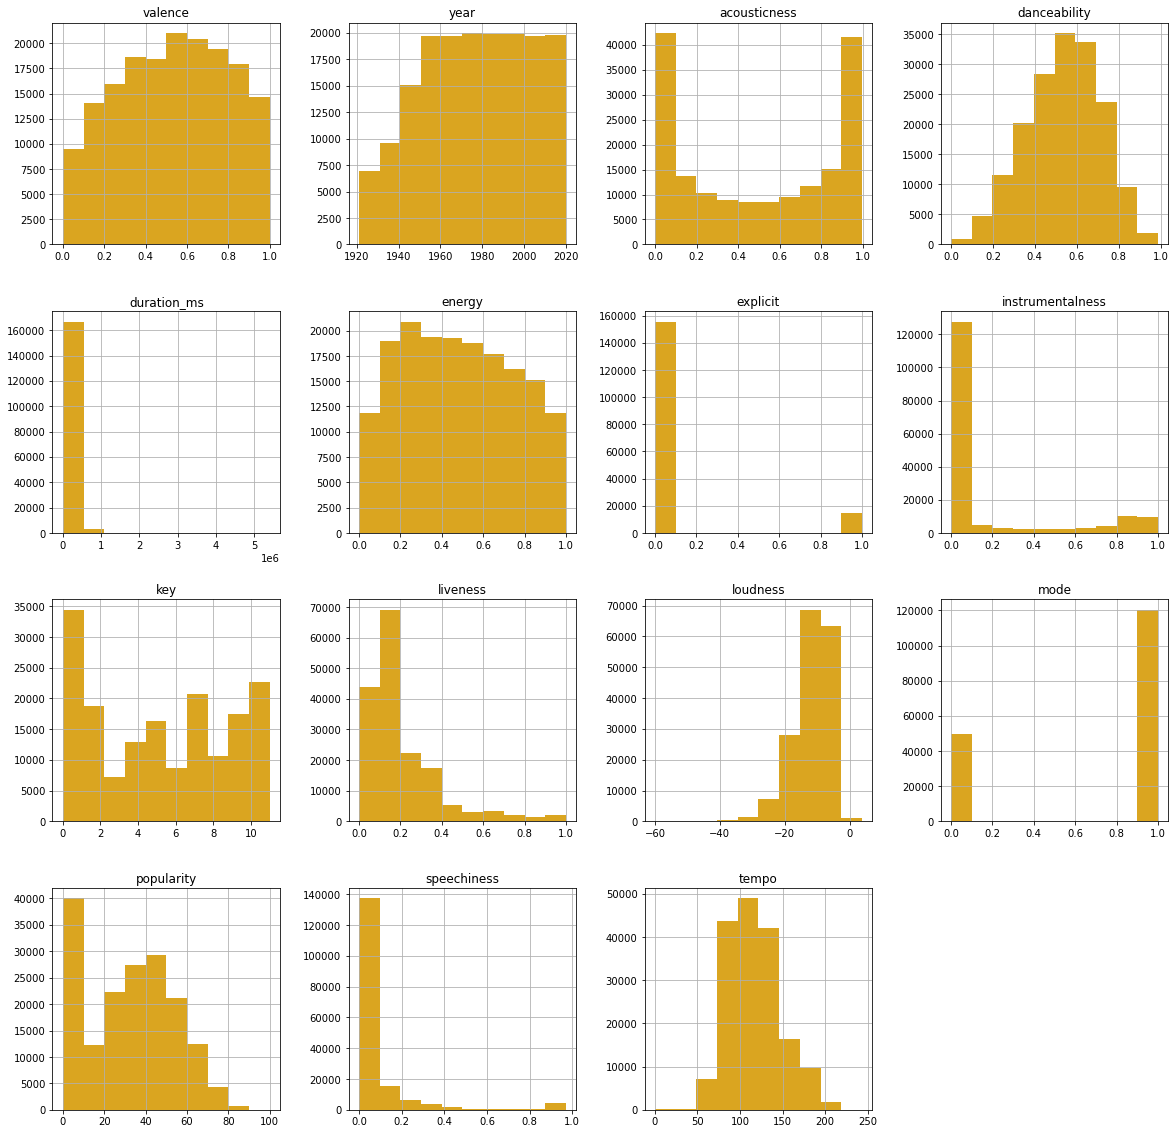

In [355]:
df.hist(figsize = (20,20), color = 'goldenrod')
plt.show()

In [356]:
def get_corrs(df, val, corr_method, title):
    '''
    input: dataframe, floating-point value, correlation method, and output title.
    output: prints column names and correlation value if absolute value of correlation is greater than val
    '''
    print(f'Threshold of {corr_method} correlatoin on "{title}" is = {val}')
    m = df.corr(method = corr_method) #compute correlation matrix
    arr = df.corr(method = corr_method).to_numpy() #creating array for easier searching
    for i in range(len(m)): #for each row
        for j in range(len(m)): #for each col
            if i == j: #matrix is symmetric (we only need to evaluate half) so this stops it from traversing the entire array
                break
            if math.fabs(arr[i][j]) > val: #compares current element to val
                #print(m.columns[i], 'vs', m.columns[j], '\t', arr[i][j].round(3)) #print if above threshold
                print(f'{m.columns[i]:12} vs {m.columns[j] :16} --> {arr[i][j].round(3)}')

In [357]:
get_corrs(df, 0.4, 'pearson', 'Data O')
#data_df.corr()

Threshold of pearson correlatoin on "Data O" is = 0.4
acousticness vs year             --> -0.612
danceability vs valence          --> 0.558
energy       vs year             --> 0.528
energy       vs acousticness     --> -0.749
loudness     vs year             --> 0.485
loudness     vs acousticness     --> -0.56
loudness     vs energy           --> 0.782
loudness     vs instrumentalness --> -0.405
popularity   vs year             --> 0.863
popularity   vs acousticness     --> -0.571
popularity   vs energy           --> 0.483
popularity   vs loudness         --> 0.455
speechiness  vs explicit         --> 0.414


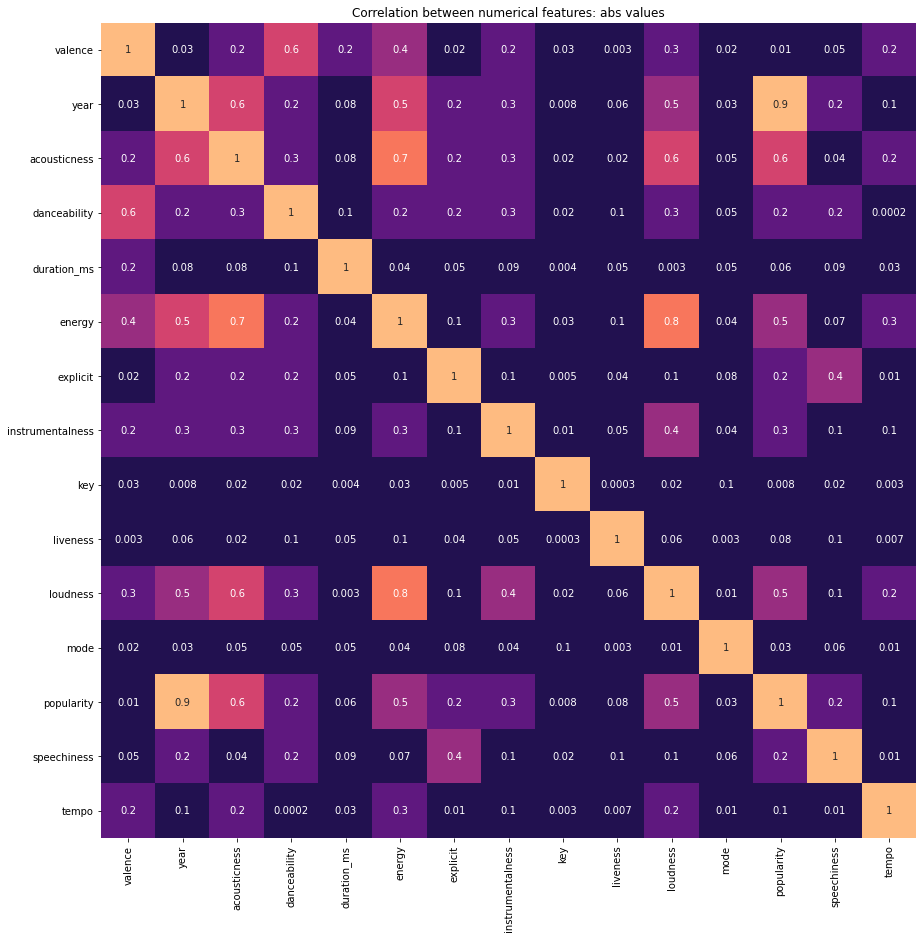

In [358]:
# Numeric Heatmap
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.color_palette("magma")
sns.heatmap(corr, cmap=cmap, square=True, annot = True, cbar=False, fmt='.1g')
plt.title('Correlation between numerical features: abs values')
plt.show()

<h1><center>Categorical Features</center></h1>

<h1>Artists</h1>

In [359]:
df['artists'].nunique()

34088

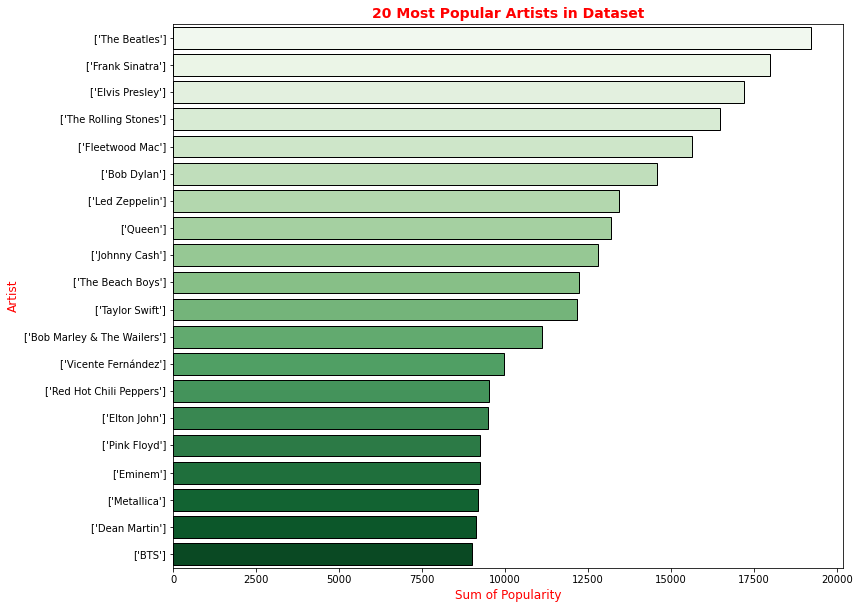

In [360]:
# # Plotting
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = df.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

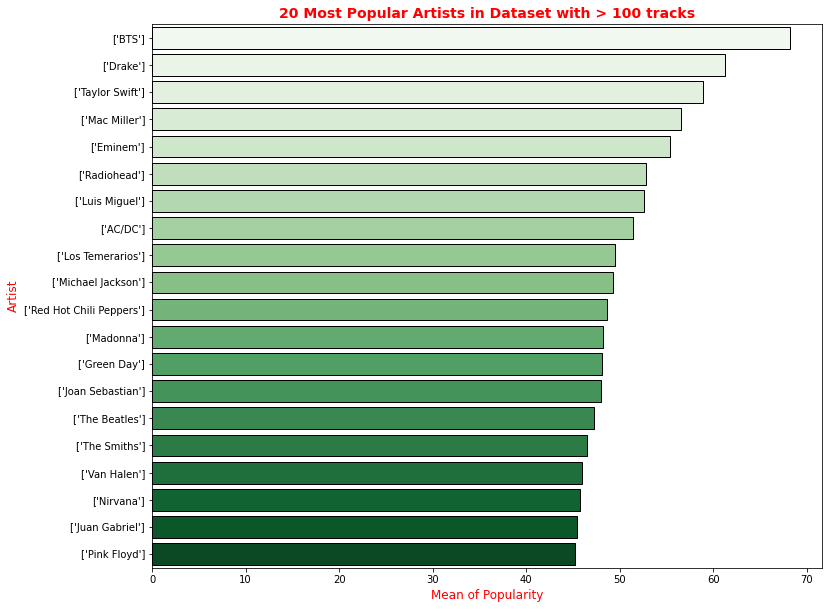

In [361]:
# find out artists with more than 100 tracks
df['popular_artist'] = df['artists'].map(df['artists'].value_counts()>100)
pop_arts  = df.groupby(['artists', 'popular_artist'])['popularity'].mean().sort_values(ascending=False).reset_index(1)
df_pop_arts = pop_arts.loc[pop_arts['popular_artist'] == True,['popularity']]

# # Plotting
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = df_pop_arts.groupby('artists')['popularity'].mean().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Mean of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset with > 100 tracks', c='r', fontsize=14, weight = 'bold')
plt.show()

* There are 34,088 different artists in this feature.

* Since we believe there should be a correlation between the artist and the popularity of the track, we would like to use the Target Encoding approach, and replace the artist with some derivative of its popularity.

* First, we check distribution of number of times artists appear in the data.

* It is clear that most artists apear less than 50 times

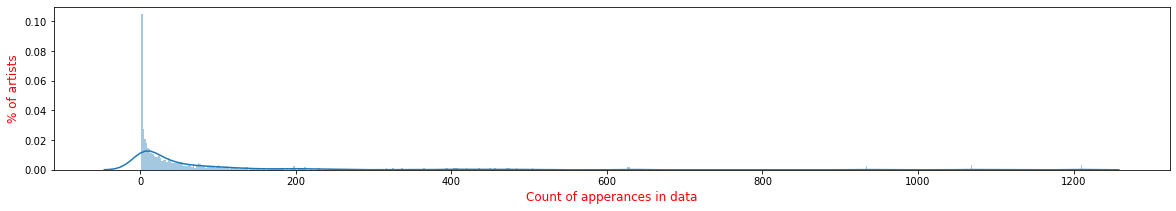

In [362]:
# Adding Mean & Count values to each artist
df['mean'] = df.groupby('artists')['popularity'].transform('mean')
df['count'] = df.groupby('artists')['popularity'].transform('count')
# plotting
fig, ax = plt.subplots(figsize = (20, 3))
ax = sns.distplot(df['count'], bins = 600)
ax.set_xlabel('Count of apperances in data', fontsize=12, c='r')
ax.set_ylabel('% of artists', fontsize=12, c='r')
plt.show()

* Lets zoom in to the left of the scale, to decide what is the cut-off for using artist mean OR overall data mean:

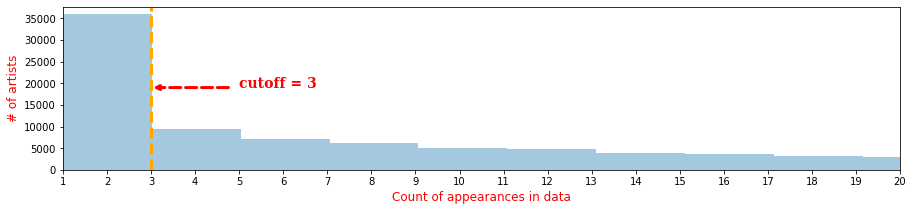

In [363]:
fig, ax = plt.subplots(figsize = (15, 3))
ax = sns.distplot(df['count'], bins=600, kde=False)
ax.set_xlabel('Count of appearances in data', fontsize=12, c='r')
ax.set_ylabel('# of artists', fontsize=12, c='r')
ax.set_xlim(1,20)
ax.set_xticks(range(1,21,1))
ax.axvline(x=3, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)
font = {'family': 'serif',
        'color':  'red',
        'weight': 'bold',
        'size': 14,
        }
ax.annotate("", xy=(3, 19000), xytext=(4.8, 19000), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3))
ax.text(x = 5, y = 19000, s='cutoff = 3', fontdict=font)

plt.show()

* We also check for correlation between the number of appearances in data and the mean of popularity.

* It is clear that artists that appear in the data more than 600 times, are getting almost 0 popularity.

* There are 4 artists ['Эрнест Хемингуэй', 'Эрих Мария Ремарк', Francisco Canaro, Frank Sinatra, Ignacio Corsini] responsible for 4,471 tracks!

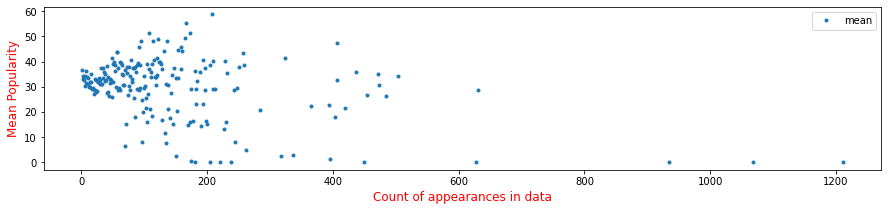

In [364]:
fig, ax = plt.subplots(figsize = (15, 3))
stat = df.groupby('count')['mean'].mean().to_frame().reset_index()
ax = stat.plot(x='count', y='mean', marker='.', linestyle = '', ax=ax)
ax.set_xlabel('Count of appearances in data', fontsize=12, c='r')
ax.set_ylabel('Mean Popularity', fontsize=12, c='r')
plt.show()

In [365]:
frequent_flyer = df[['artists','mean']].loc[df['count']>600].value_counts(ascending=False).reset_index()
frequent_flyer.columns=['Artist','Mean Popularity', '# of Tracks']
frequent_flyer

Artist  Mean Popularity  # of Tracks
0   ['Эрнест Хемингуэй']         0.066061         1211
1  ['Эрих Мария Ремарк']         0.000000         1068
2   ['Francisco Canaro']         0.059957          934
3      ['Frank Sinatra']        28.550794          630
4    ['Ignacio Corsini']         0.031847          628

1) Therefore to handle this feature we will use a transformer that transforms the 'artists' feature from object to a float value as follows:

2) Replace the data with the artists mean popularity

3) Replace values where artists appear less than minimal times with popularity mean

4) Replace values where artists appear more than maximaum times with 0

<h1>Keys</h1>

1) The 11-values of keys distribute between 4-13% each

2) Keys popularity' std is aprox. 20, makes it difficult to establish any correlation.

3) Key 3 has the lowest mean (of 24.67)

In [366]:
df['duration_ms'].corr(df['popularity'])

0.05956016246083312

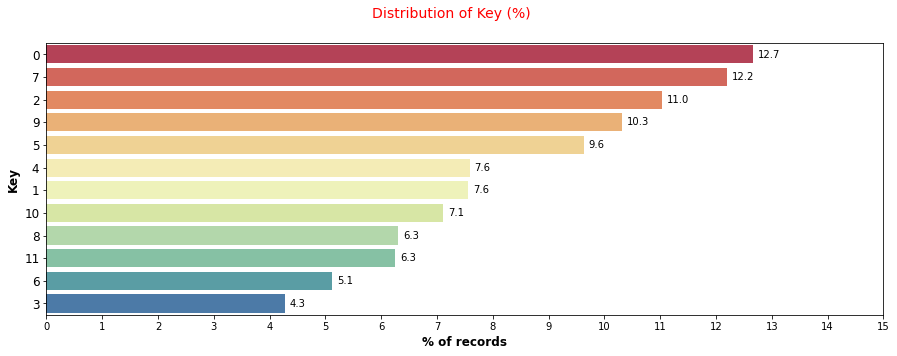

In [367]:
fig, ax = plt.subplots(figsize = (15, 5))
key_data = df['key'].value_counts(normalize=True, sort=True, ascending=True)*100
y_ticks = df['key'].value_counts().index
ax = sns.barplot(x = key_data.values, y= y_ticks, data = key_data, orient='h', palette='Spectral')
ax.set_xlabel('% of records', fontsize=12, weight='bold')
ax.set_ylabel('Key', fontsize=12, weight='bold')
ax.set_xlim(0.0,15.0, 0)
ax.set_xticks(ticks=range(0,16,1))
ax.set_yticklabels(labels=y_ticks, fontsize=12) #

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width() #f'{rect.get_width():.2f}'
    y_value = rect.get_y() + rect.get_height() / 2
    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # Use X value as label and format number with one decimal place
    label = f'{x_value:.1f}'
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.suptitle('Distribution of Key (%)', fontsize=14, c='r')
plt.show()


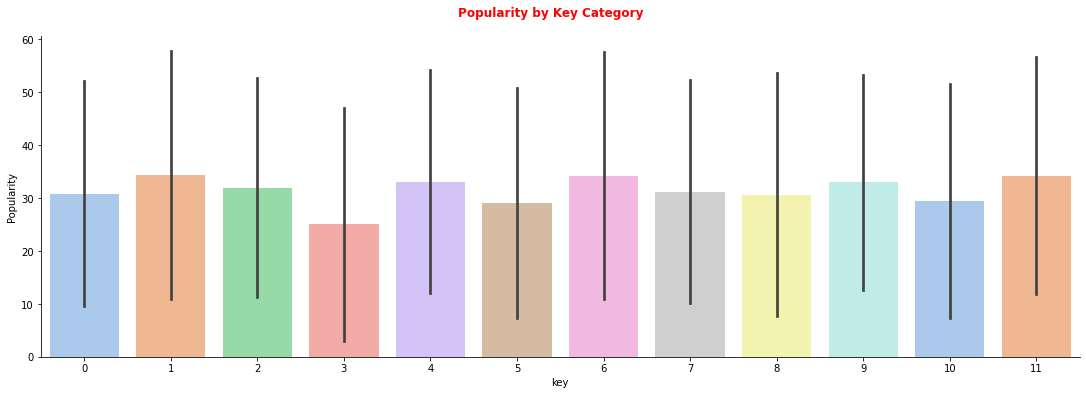

In [368]:
exp_data = sns.catplot(data=df, kind="bar",
                        x="key", y="popularity",
                        palette='pastel',
                        ci = 'sd',
                        height=5, aspect = 3)
exp_data.fig.suptitle('Popularity by Key Category', y=1.05, c='r', weight='bold')
exp_data.set_axis_labels("key", "Popularity")
plt.show()

<h1>Mode</h1>

1) Mode is a binary feature.

2) There is no distinguish linear connection between mode and popularity (corr = -0.033)

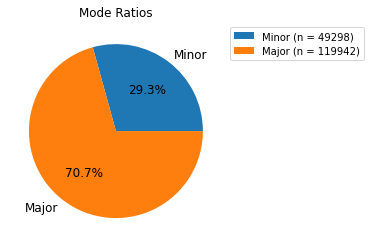

In [369]:
ax = df.groupby('mode')['popularity'].count().plot.pie(labels=['Minor', 'Major'],
                                 autopct='%1.1f%%', 
                                 fontsize=12)
ax.set_ylabel('')
ax.set_title('Mode Ratios')
ax.legend(labels=['Minor (n = 49298)', 'Major (n = 119942)'], bbox_to_anchor=(1, 1))
a = ax.get_anchor
plt.show()

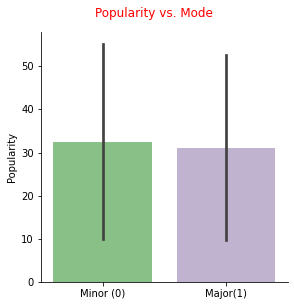

In [370]:
exp_data = sns.catplot(data=df, kind="bar",
                        x="mode", y="popularity",
                        ci="sd", palette='Accent',
                        height=4)
exp_data.fig.suptitle('Popularity vs. Mode', y=1.05, c='r')
exp_data.set_axis_labels("", "Popularity")
exp_data.set_xticklabels(['Minor (0)', 'Major(1)'])
plt.show()

<h1><center>Numeric Features</center></h1>

<h1>Acousticness</h1>

1) The acousticness of the majority of tracks is either close to 0 or 1

2) The more confidence we have that a track is acoustic, the less is its mean popularity (apply for acousitcness > 0.1)

In [371]:
a= df['acousticness'].corr(df['popularity']).round(2)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  -0.57   


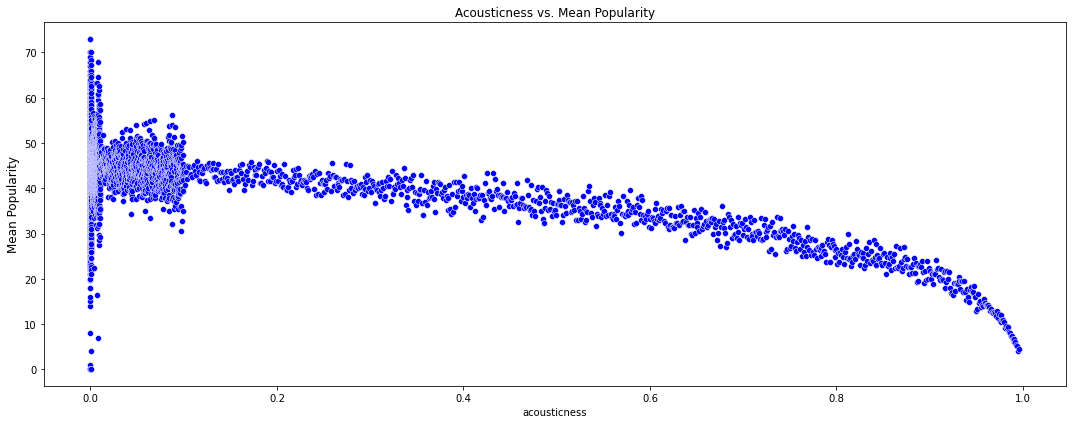

In [372]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x = ax1_data['acousticness'], y = ax1_data['popularity'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

<h1>Danceability</h1>

1) Danceability- measure if the song is dancable based on the combination of tempo rythm and beat strength

2) Danceability seems to have a normal distribution between 0-1

3) the majoirity of Danceability values is between 0.2-0.8 with mean 0.53

In [373]:
a= df['danceability'].corr(df['popularity']).round(2)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->   0.2    


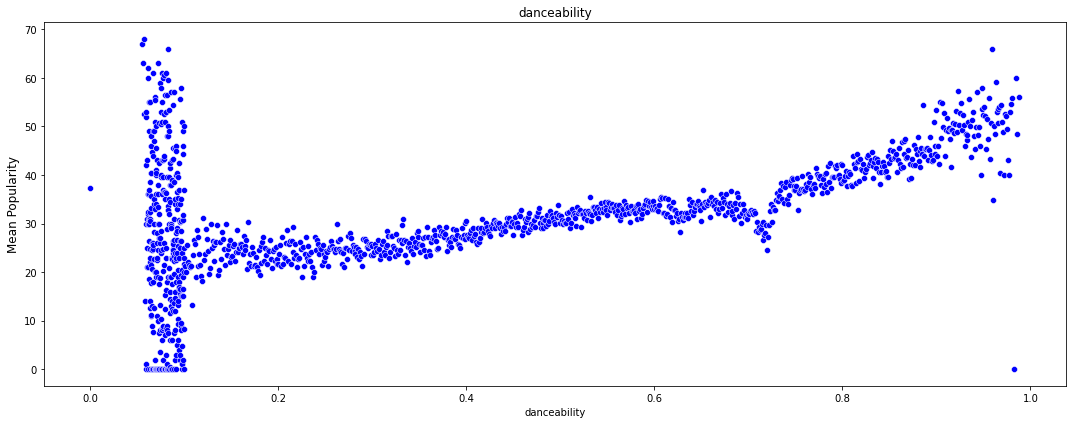

In [374]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

<h1>Energy</h1>
1) mesure the intensity and activity, energetic track feels faster, louder and noisier.

2) It seem tat there is a releativly strong linear correlation of 0.483 correlation to the target.

In [375]:
a= df['energy'].corr(df['popularity']).round(3)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  0.483   


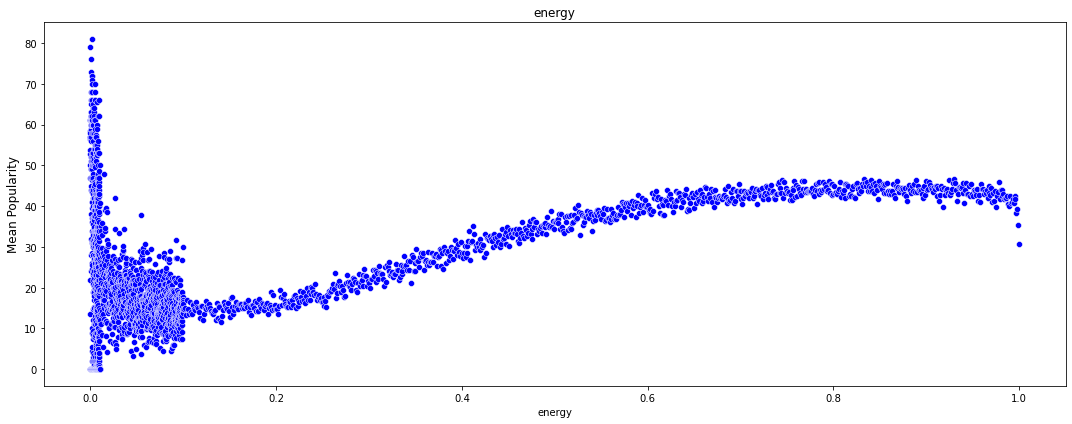

In [376]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('energy')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='energy', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('energy')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

<h1>Instrumentalness</h1>
1) The closer the Instrumentalness to 1 - the greater liklyhood the track contains NO vocals

2) Most of the data is distributed in both sides of scope.

2) We decide to divide the feature into three categorical groups and create a onehotencoder transformer to reshpae our data

In [377]:
a= df['instrumentalness'].corr(df['popularity']).round(3)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  -0.293  


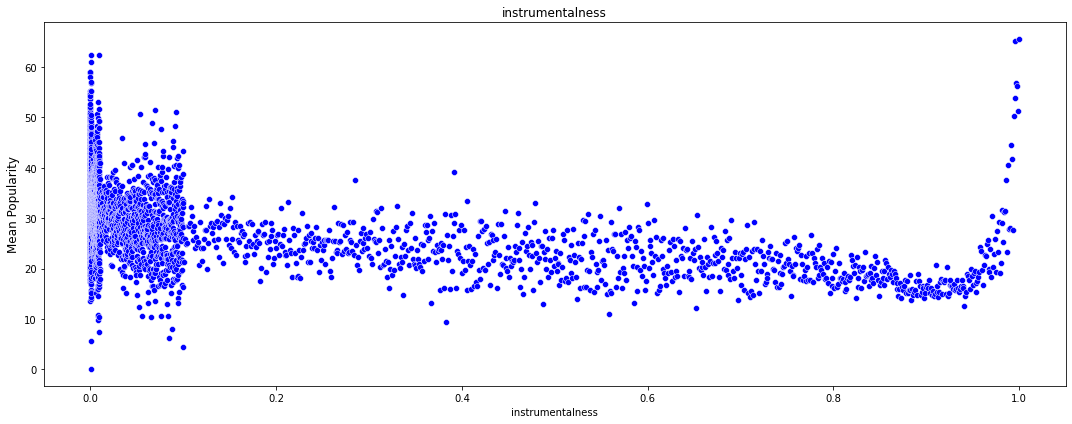

In [378]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

<h1>Liveness</h1>
1) Detects the presence of an audience. high livness suggests of the track was live

In [379]:
a= df['liveness'].corr(df['popularity']).round(3)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  -0.077  


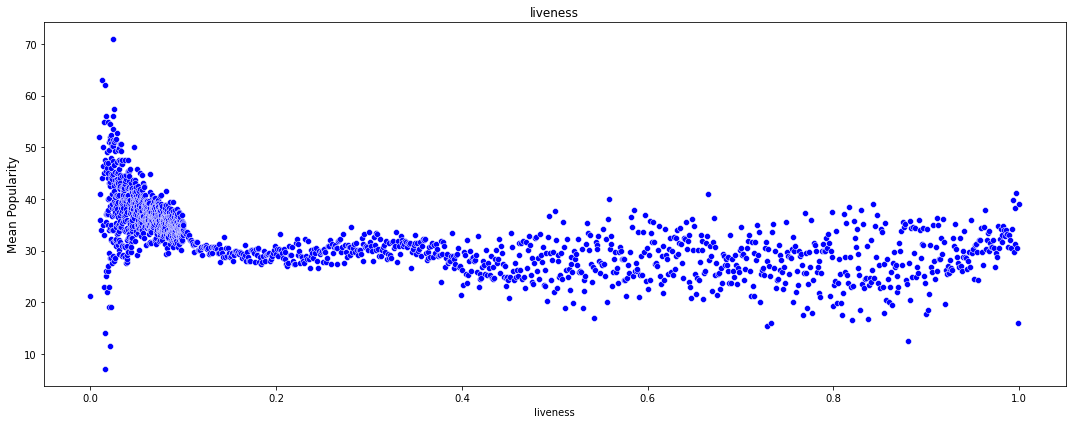

In [380]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('liveness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='liveness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.set_title('liveness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

<h1>Loudness</h1>

In [381]:
df['loudness'].corr(df['popularity'])

0.4551678001870109

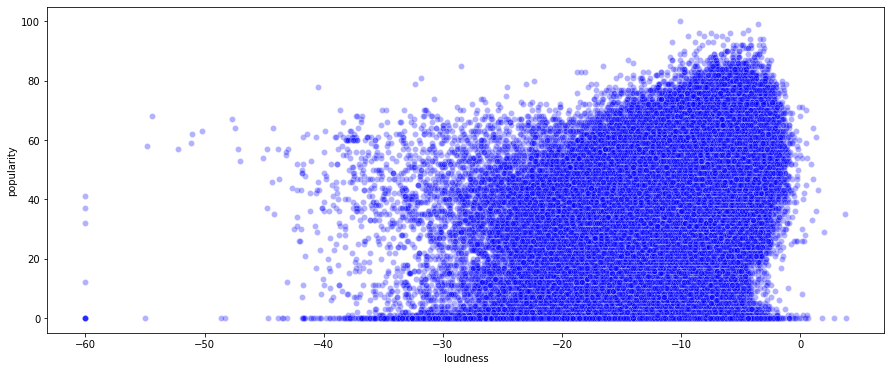

In [382]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='loudness', y='popularity', data=df, color='blue', alpha=0.3)
plt.show()

In [383]:
series = np.abs(corr['popularity']).sort_values(ascending=False)
print('The most linear correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:
        print(f'{series.index[i]:17} --> {row: .2f} (abs)')

The most linear correlated features to POPULARITY are:
year              -->  0.86 (abs)
acousticness      -->  0.57 (abs)
energy            -->  0.48 (abs)
loudness          -->  0.46 (abs)
instrumentalness  -->  0.29 (abs)


<h1>Popularity (Target)</h1>

In [384]:
# Describe - all
df['popularity'].describe()

count    170025.000000
mean         31.535892
std          21.784935
min           0.000000
25%          12.000000
50%          34.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [385]:
# Describe - Popularity > 0
df.loc[df['popularity']>0,'popularity'].describe()

count    142701.000000
mean         37.574299
std          18.400148
min           1.000000
25%          25.000000
50%          38.000000
75%          51.000000
max         100.000000
Name: popularity, dtype: float64

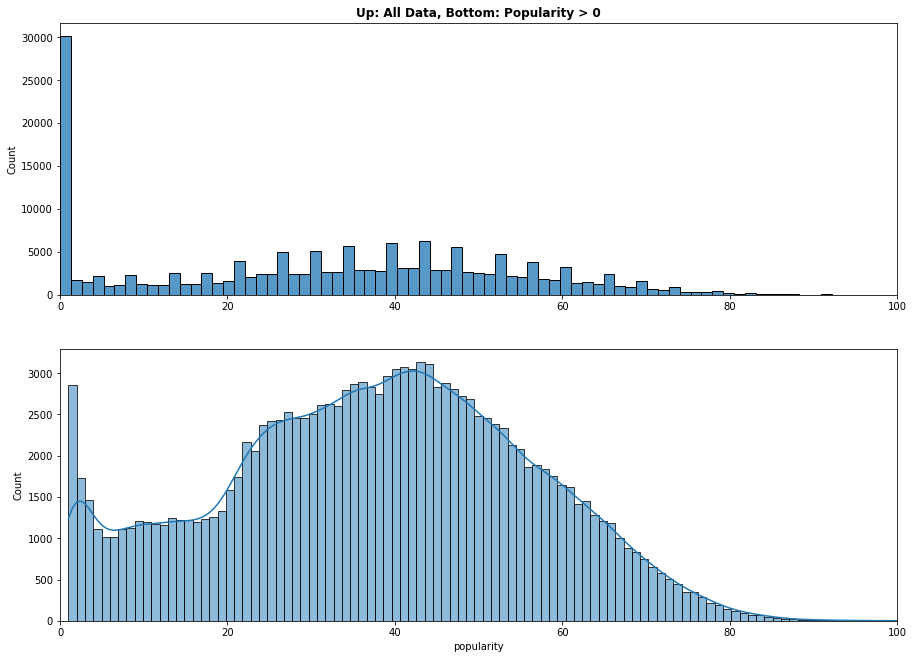

In [386]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11))
ax1 = sns.histplot(data=df, x=df['popularity'], ax=ax1)
ax2 = sns.histplot(data=df, x=df.loc[df['popularity']>0,'popularity'], ax=ax2, kde=True)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100)
ax1.set_xlabel('')
ax1.set_title('Up: All Data, Bottom: Popularity > 0', weight='bold')
plt.show()

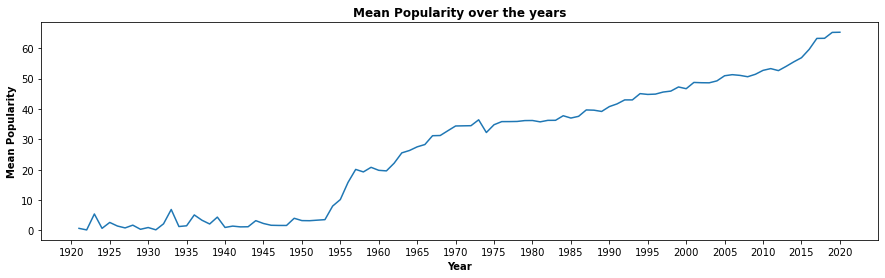

In [387]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = df.groupby('year')['popularity'].mean().plot()
ax.set_title('Mean Popularity over the years', weight='bold')
ax.set_ylabel('Mean Popularity', weight='bold')
ax.set_xlabel('Year', weight='bold')
ax.set_xticks(range(1920, 2021, 5))
plt.show()

<h1>Speechiness</h1>

1) Due to an obvious change in in speechiness trand vs. poopularity, we decided to divide the records into two sub-groups.

 2)  The cutoff point is based on a decision tree model.

In [388]:
a= df['speechiness'].corr(df['popularity']).round(2)
print(f'The pearson corr is -->{a:^10}')

The pearson corr is -->  -0.17   


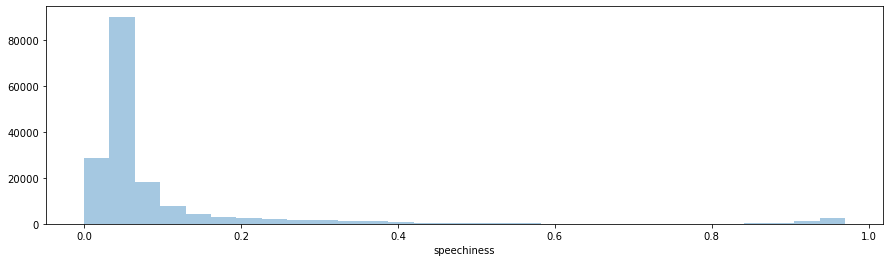

In [389]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(df['speechiness'], kde = False, bins=30)
plt.show()

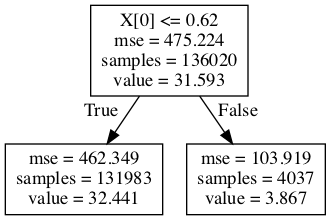

In [390]:
X_sp = df['speechiness'].to_frame()
y_sp = df['popularity']
X_train, X_test, y_train, y_test = split(X_sp, y_sp , test_size = 0.2 , random_state = 42 )
model = DecisionTreeRegressor(max_leaf_nodes=2)
model = model.fit(X_train, y_train)


dot_data = StringIO()
export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

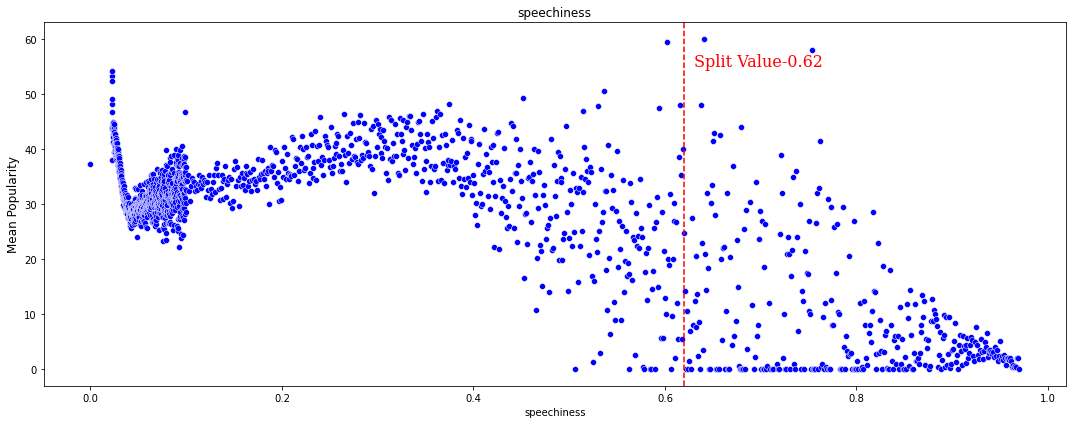

In [391]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='speechiness', y='popularity', data=ax_data, color='blue', ax=ax)
ax.axvline(x=0.62,ymin=0,ymax=1,color='red',linestyle='dashed')
font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        }
ax.text(x = 0.63, y = 55, s='Split Value-0.62',fontdict=font)
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

<h1>Tempo</h1>

1)The linear correlation between tempo and popularity is 0.1335.

2) Outliers - there is a 145 values of 0. need to be replaced.

3) This feature will need a scaler.

In [392]:
a = df['tempo'].corr(df['popularity']).round(2)
print(f"Linear correlation is {a}")

Linear correlation is 0.13


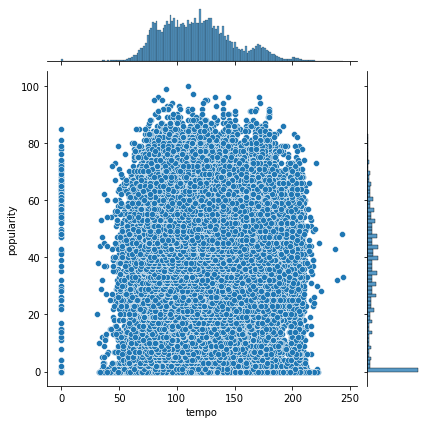

In [393]:
sns.jointplot(x='tempo', y='popularity', data=df)
plt.show()

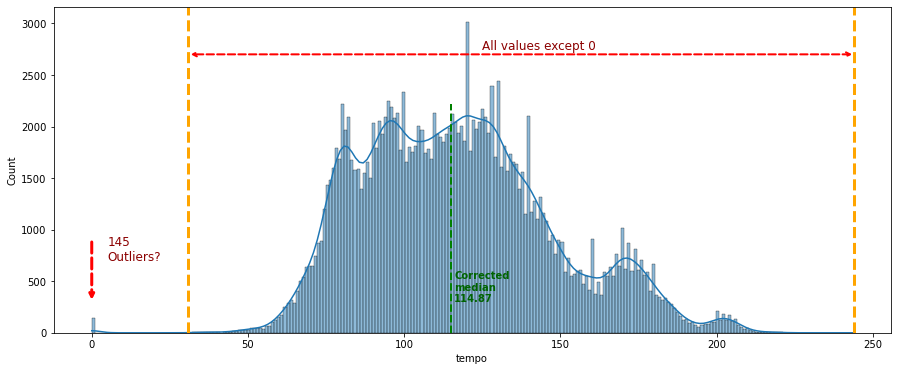

In [394]:
fig, ax = plt.subplots(figsize = (15, 6))
ax = sns.histplot(x='tempo', data=df, bins=250, kde=True)
ax.text(s='145\nOutliers?', x= 5, y=700, fontdict={'size': 12, 'c': 'darkred'})
ax.text(s='All values except 0', x= 125, y=2750, fontdict={'size': 12, 'c': 'darkred'})
ax.text(s='Corrected\nmedian\n114.87', x= 116, y=300, fontdict={'size': 10, 'c': 'darkgreen', 'weight': 'bold'})
ax.axvline(x=114.87, ymin=0, ymax=0.7, color='green', linestyle='dashed', linewidth=2)
ax.axvline(x=30.95, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)
ax.axvline(x=244.09, ymin=0, ymax=1, color='orange', linestyle='dashed', linewidth=3)
ax.annotate("", xy=(31, 2700), xytext=(244, 2700), arrowprops=dict(arrowstyle="<->", color='r', linestyle='dashed', linewidth=2))
ax.annotate("", xy=(0, 300), xytext=(0, 900), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3))
plt.show()

<h1>Valence</h1>

In [395]:
a = df['valence'].corr(df['popularity']).round(2)
print(f"Linear correlation is {a}")

Linear correlation is 0.01


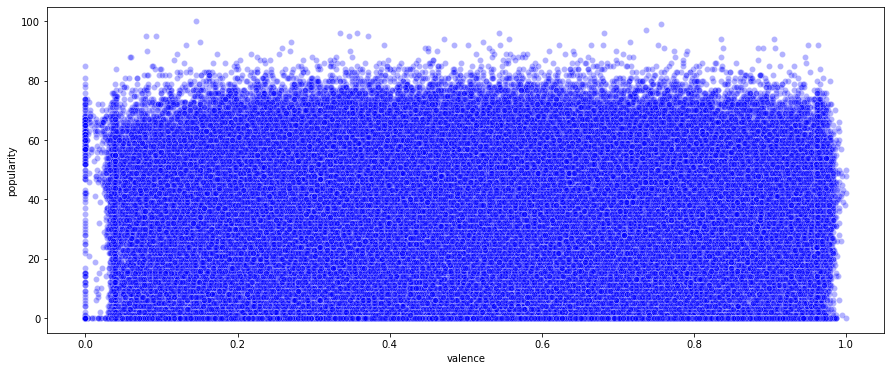

In [396]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='valence', y='popularity', data=df, color='blue', alpha=0.3)
plt.show()

<h1>Year</h1>

1) The year attribute is linearly close to the popularity target (corr = 0.86)

2) Each year contains different quantities of tracks. Most of the years are up to 2000, probably due to the 2000 maximal batch limit in the Spoyify's API.

3) There are some values with 0 popularity in 2020. These is a relatively new songs in the dataset, from 6/2020, prior to data extraction.

In [397]:
a = df['year'].corr(df['popularity']).round(2)
print(f"Linear correlation is {a}")

Linear correlation is 0.86


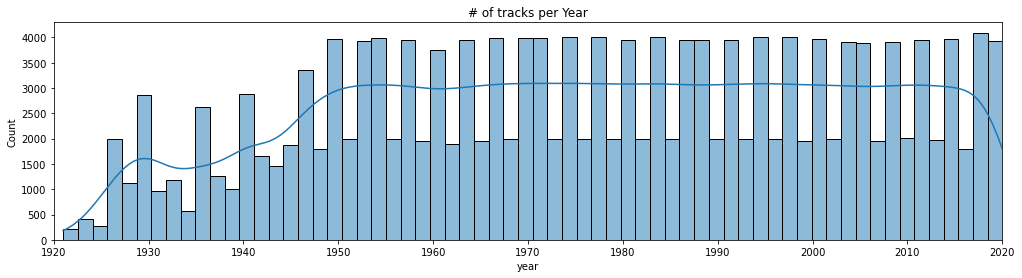

In [398]:
fig, ax = plt.subplots(figsize=(17, 4))
ax = sns.histplot(data=df, x='year', kde=True)
ax.set_xlim(1920,2020)
ax.set_xticks(range(1920, 2021, 10))
ax.set_title('# of tracks per Year')
plt.show()

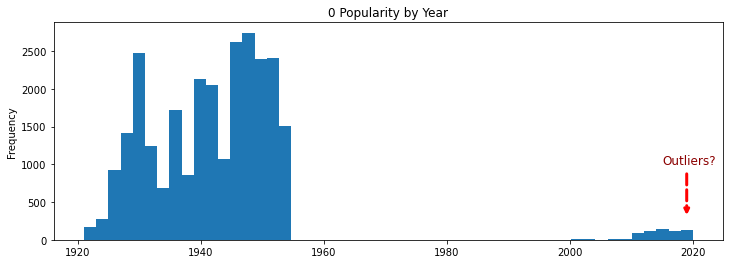

In [399]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = df['year'].loc[df['popularity']==0].plot.hist(bins=50)
ax.set_title('0 Popularity by Year')
ax.text(s='Outliers?', x= 2015, y=1000, fontdict={'size': 12, 'c': 'darkred'})
ax.annotate("", xy=(2019, 300), xytext=(2019, 900), arrowprops=dict(arrowstyle="->", color='r', linestyle='dashed', linewidth=3))
plt.show()

Due to the very high linear correlation between the year and the popularity, this feature will be excluded from our models.

<h1><center>Pre-Processing</center></h1>

First, we import a clean version of the data, without id, name, year and release_date and remove the duplicates

In [400]:
file = 'data/data_o.csv'
cols = list(pd.read_csv(file, nrows =1))
df = pd.read_csv(file, usecols=[i for i in cols if i not in ['id','name','release_date','year']])

# Remove duplicated
df = df[~df.duplicated()==1]
#df = df.sample(frac=0.3)

<h1>Data splitting</h1>

In [401]:
X_train, X_test, y_train, y_test = split(df.drop('popularity', axis=1), df['popularity'], 
                                         test_size = 0.20, random_state = 42)


In [402]:
nl = '\n'
print(f'X_train shape is: {X_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {X_test.shape} {nl}y_test shape is: {y_test.shape}')

X_train shape is: (135813, 14) 
y_train shape is: (135813,) 
X_test shape is: (33954, 14) 
y_test shape is: (33954,)


In [403]:
X_train.head(3)

valence  acousticness                          artists  danceability  \
83365     0.584         0.128              ['David Allan Coe']         0.482   
104060    0.373         0.425                  ['Blind Melon']         0.416   
25561     0.226         0.965  ['Percy Faith', 'Mitch Miller']         0.201   

        duration_ms  energy  explicit  instrumentalness  key  liveness  \
83365        233000   0.655         0          0.000000    9    0.0999   
104060       195680   0.521         0          0.000002    4    0.2440   
25561        158533   0.291         0          0.863000    3    0.0915   

        loudness  mode  speechiness    tempo  
83365    -11.407     1       0.0389  158.644  
104060    -7.922     0       0.0270   80.421  
25561    -14.605     1       0.0370   71.013

**AritistsTransformer**

*Here we need to replace string data of the artists with some numerical indicator that identify the artist.*

In [404]:

class ArtistsTransformer():

    def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
        self.MinCnt = MinCnt
        self.MaxCnt = MaxCnt
        self.artists_df = None
  
    def fit (self, X, y):
        self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
        self.artists_df.loc['unknown'] = [y.mean(), 1]
        self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
        self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
        return self

    def transform(self, X, y=None):
        X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
        X['artists'] = X['artists'].map(self.artists_df['mean'])
        return X
        
        
# Apply AritistsTransformer on train and test seperatly
artists_transformer = ArtistsTransformer(MinCnt=2)
X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
X_test = artists_transformer.transform(X_test, y_test)
X_train.head()


valence  acousticness    artists  danceability  duration_ms  energy  \
83365     0.584       0.12800  32.948276         0.482       233000   0.655   
104060    0.373       0.42500  42.210526         0.416       195680   0.521   
25561     0.226       0.96500  12.857143         0.201       158533   0.291   
72938     0.597       0.00348  54.227273         0.461       208253   0.890   
30665     0.714       0.10400  38.130435         0.640       472973   0.886   

        explicit  instrumentalness  key  liveness  loudness  mode  \
83365          0          0.000000    9    0.0999   -11.407     1   
104060         0          0.000002    4    0.2440    -7.922     0   
25561          0          0.863000    3    0.0915   -14.605     1   
72938          0          0.000000   10    0.0953    -5.167     0   
30665          0          0.000005    8    0.3070    -4.951     1   

        speechiness    tempo  
83365        0.0389  158.644  
104060       0.0270   80.421  
25561        0.0370   71.013  
72938        0.0628  155.050  
30665        0.0632   82.417

**Instrumentalness Transformer**

In [405]:
def instrumentalness_criteria(X):
    X['instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(X_train)
instrumentalness_tranformer.transform(X_test)

In [406]:
X_train.head()

valence  acousticness    artists  danceability  duration_ms  energy  \
83365     0.584       0.12800  32.948276         0.482       233000   0.655   
104060    0.373       0.42500  42.210526         0.416       195680   0.521   
25561     0.226       0.96500  12.857143         0.201       158533   0.291   
72938     0.597       0.00348  54.227273         0.461       208253   0.890   
30665     0.714       0.10400  38.130435         0.640       472973   0.886   

        explicit  instrumentalness  key  liveness  loudness  mode  \
83365          0                 1    9    0.0999   -11.407     1   
104060         0                 1    4    0.2440    -7.922     0   
25561          0                 2    3    0.0915   -14.605     1   
72938          0                 1   10    0.0953    -5.167     0   
30665          0                 1    8    0.3070    -4.951     1   

        speechiness    tempo  
83365        0.0389  158.644  
104060       0.0270   80.421  
25561        0.0370   71.013  
72938        0.0628  155.050  
30665        0.0632   82.417

**Tempo Transformer**

*Removes Zero values from tempo columns and replace it with the median or mean of values as specified.
Defaut is set to 'median'.*

In [407]:
class ReplaceZeroTransformer():

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

tempo_transformer = ReplaceZeroTransformer()
X_train = tempo_transformer.transform(X_train)
X_test = tempo_transformer.transform(X_test)

In [408]:
X_train.head()

valence  acousticness    artists  danceability  duration_ms  energy  \
83365     0.584       0.12800  32.948276         0.482       233000   0.655   
104060    0.373       0.42500  42.210526         0.416       195680   0.521   
25561     0.226       0.96500  12.857143         0.201       158533   0.291   
72938     0.597       0.00348  54.227273         0.461       208253   0.890   
30665     0.714       0.10400  38.130435         0.640       472973   0.886   

        explicit  instrumentalness  key  liveness  loudness  mode  \
83365          0                 1    9    0.0999   -11.407     1   
104060         0                 1    4    0.2440    -7.922     0   
25561          0                 2    3    0.0915   -14.605     1   
72938          0                 1   10    0.0953    -5.167     0   
30665          0                 1    8    0.3070    -4.951     1   

        speechiness    tempo  
83365        0.0389  158.644  
104060       0.0270   80.421  
25561        0.0370   71.013  
72938        0.0628  155.050  
30665        0.0632   82.417

**OneHotEncoder**  

*Using SKlearn to create dummies*

In [409]:
ohe = OneHotEncoder(categories='auto', drop='first')

# Training
feature_arr = ohe.fit_transform(X_train[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_train['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_train['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = X_train.index)
X_train = pd.concat([X_train, features], axis=1).drop(['key','instrumentalness'], axis=1)

# Validation
feature_arr = ohe.fit_transform(X_test[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_test['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_test['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = X_test.index)
X_test = pd.concat([X_test, features], axis=1).drop(['key','instrumentalness'], axis=1)

In [410]:
#MinMaxScaler Encoder
scaler = MinMaxScaler()
cols = ['duration_ms','loudness','tempo']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

In [411]:
#Target scaling
# Divide the popularity by 100
y_train = y_train / 100
y_test = y_test / 100

In [412]:
#verify
nl = '\n'
print(f'X_train shape is: {X_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {X_test.shape} {nl}y_test shape is: {y_test.shape}')

X_train shape is: (135813, 25) 
y_train shape is: (135813,) 
X_test shape is: (33954, 25) 
y_test shape is: (33954,)


In [413]:
X_train.head()

valence  acousticness    artists  danceability  duration_ms  energy  \
83365     0.584       0.12800  32.948276         0.482     0.042215   0.655   
104060    0.373       0.42500  42.210526         0.416     0.035302   0.521   
25561     0.226       0.96500  12.857143         0.201     0.028421   0.291   
72938     0.597       0.00348  54.227273         0.461     0.037631   0.890   
30665     0.714       0.10400  38.130435         0.640     0.086667   0.886   

        explicit  liveness  loudness  mode  ...  key_4  key_5  key_6  key_7  \
83365          0    0.0999  0.762315     1  ...    0.0    0.0    0.0    0.0   
104060         0    0.2440  0.816987     0  ...    0.0    0.0    1.0    0.0   
25561          0    0.0915  0.712145     1  ...    0.0    1.0    0.0    0.0   
72938          0    0.0953  0.860206     0  ...    0.0    0.0    0.0    0.0   
30665          0    0.3070  0.863595     1  ...    0.0    0.0    0.0    0.0   

        key_8  key_9  key_10  key_11  ins_2  ins_3  
83365     0.0    0.0     0.0     1.0    0.0    0.0  
104060    0.0    0.0     0.0     0.0    0.0    0.0  
25561     0.0    0.0     0.0     0.0    0.0    0.0  
72938     0.0    0.0     0.0     0.0    1.0    0.0  
30665     0.0    0.0     1.0     0.0    0.0    0.0  

[5 rows x 25 columns]

<h1><center>Models!</center></h1>

<h1>1) Linear Regression</h1>

**Option 1: selected features only (corr > 0.2)**

In [414]:
LR = LinearRegression()
cols = [col for col in X_train.columns if abs(X_train[col].corr(y_train))>0.2]

# Fit the model and
LR.fit(X_train.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train.drop(columns=cols)).clip(0, 1)
# RMSE Train
LR_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_tr = r2_score(y_train, y_train_pred)
print(f"RMSE Train = {LR_rmse:.5f}")
print(f"R2 Train = {r2_tr:.5f}")


#Predicting with the model
y_test_pred = LR.predict(X_test.drop(columns=cols)).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_tr = r2_score(y_test, y_test_pred)
print(f"RMSE Test = {LR_rmse:.5f}")
print(f"R2 Test = {r2_tr:.5f}")

RMSE Train = 0.19481
R2 Train = 0.19933
RMSE Test = 0.19434
R2 Test = 0.20212


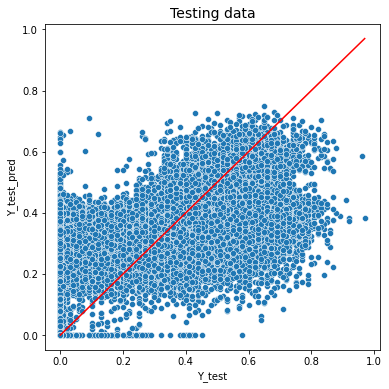

In [415]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('Testing data', fontsize=14)
plt.show()

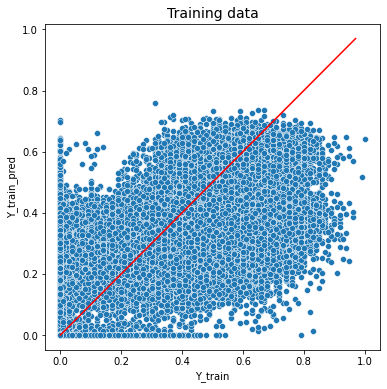

In [416]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('Y_train_pred')
ax.set_title('Training data', fontsize=14)
plt.show()

**Option 2: All features**

In [417]:
LR = LinearRegression()

# Fit the model and
LR.fit(X_train, y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train)

# RMSE Train
LR_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_tr = r2_score(y_train, y_train_pred)
print(f"RMSE Train = {LR_rmse:.6f}")
print(f"R2 Train = {r2_tr:.6f}")

#Predicting with the model
y_test_pred = LR.predict(X_test)

# RMSE Test
LR_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_te = r2_score(y_test, y_test_pred)
print(f"RMSE Valid = {LR_rmse:.6f}")
print(f"R2 Test = {r2_te:.6f}")
#print('Validation accuracy : ', r2_score(y_test, y_test_pred)*100)

RMSE Train = 0.125914
R2 Train = 0.665519
RMSE Valid = 0.131651
R2 Test = 0.633842


**Using various metrics to check the results**

In [418]:
print("Training Score of Linear Regression is: {}\n".format(LR.score(X_train, y_train)))
print("Testing Score of Linear Regression is: {}\n".format(LR.score(X_test, y_test)))
print("R2 Score of Linear Regression is: {}\n".format(r2_score(y_test, y_test_pred)))
print("Mean Squared Error of Linear Regression is: {}\n".format(mean_squared_error(y_test, y_test_pred)))
print("Mean Absolute Error of Linear Regression is: {}\n".format(mean_absolute_error(y_test, y_test_pred)))

Training Score of Linear Regression is: 0.6655187694220817

Testing Score of Linear Regression is: 0.6338415172368135

R2 Score of Linear Regression is: 0.6338415172368135

Mean Squared Error of Linear Regression is: 0.017332046421693184

Mean Absolute Error of Linear Regression is: 0.09909051246209057



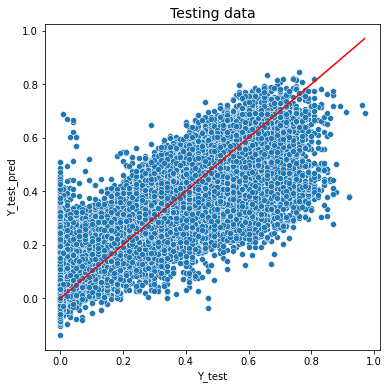

In [419]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('Testing data', fontsize=14)
plt.show()

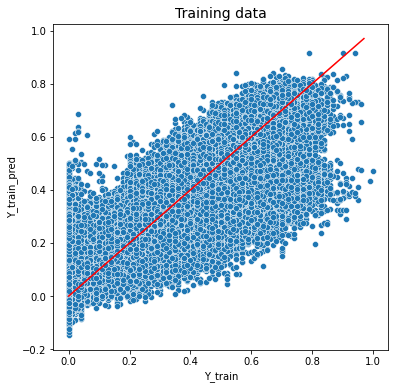

In [420]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('Y_train_pred')
ax.set_title('Training data', fontsize=14)
plt.show()

<h1>2) Decision Tree Model</h1>

In [421]:
#it will take around 5 mins to execute.

RMSE3_train, RMSE3_test = [], []
r2_train = []
r2_test = []

for e in range(2,201):
    tree = DecisionTreeRegressor(random_state = 15, max_leaf_nodes= e)
    tree.fit(X_train, y_train)
    
#Training
    y_train_pred = tree.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_tr = r2_score(y_train, y_train_pred)
    
    if e % 50 == 0 :
        print(f'At epoch {e}, Training RMSE : {train_rmse}')
        print(f'At {e} epoch, training R2 score : {r2_tr} ')
    RMSE3_train.append(train_rmse.round(3))
    r2_train.append(r2_tr)
    
#Validation    
    y_test_pred = tree.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_te = r2_score(y_test, y_test_pred)
    
    if e % 50 == 0 :
        print(f'At epoch {e}, Validation RMSE : {test_rmse}')
        print(f'At {e} epoch, validation R2 score : {r2_te} ')
    RMSE3_test.append(test_rmse.round(3))
    r2_test.append(r2_te) 

At epoch 50, Training RMSE : 0.11053047581065957
At 50 epoch, training R2 score : 0.7422565743319456 
At epoch 50, Validation RMSE : 0.11781805957230937
At 50 epoch, validation R2 score : 0.7067466460843157 
At epoch 100, Training RMSE : 0.10841161432253431
At 100 epoch, training R2 score : 0.7520437040498809 
At epoch 100, Validation RMSE : 0.11681110085895086
At 100 epoch, validation R2 score : 0.7117379372738811 
At epoch 150, Training RMSE : 0.1072537835769823
At 150 epoch, training R2 score : 0.7573117440767988 
At epoch 150, Validation RMSE : 0.11677543192703425
At 150 epoch, validation R2 score : 0.7119139553060791 
At epoch 200, Training RMSE : 0.10635658733598721
At 200 epoch, training R2 score : 0.7613550192279268 
At epoch 200, Validation RMSE : 0.11679684792632986
At 200 epoch, validation R2 score : 0.7118082786895319 


**Using various metrics to check the results**

In [193]:
print("Training Score of Decision Tree Regressor is: {}\n".format(tree.score(X_train, y_train)))
print("R2 Score of Decision Tree Regressor is: {}\n".format(r2_score(y_test, y_test_pred)))
print("Mean Squared Error of Decision Tree Regressor is: {}\n".format(mean_squared_error(y_test, y_test_pred)))
print("Mean Absolute Error of Decision Tree Regressor is: {}\n".format(mean_absolute_error(y_test,y_test_pred)))

Training Score of Decision Tree Regressor is: 0.7613550192279268

R2 Score of Decision Tree Regressor is: 0.7118082786895319

Mean Squared Error of Decision Tree Regressor is: 0.013641503685526224

Mean Absolute Error of Decision Tree Regressor is: 0.08208275075296284



**Decision Tree Plots**

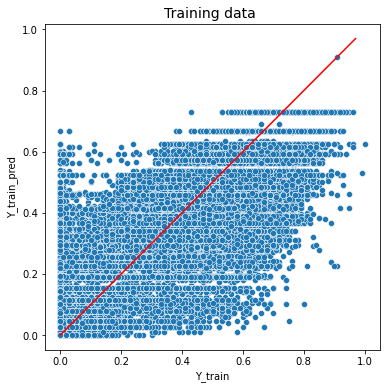

In [194]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('Y_train_pred')
ax.set_title('Training data ', fontsize=14)
plt.show()

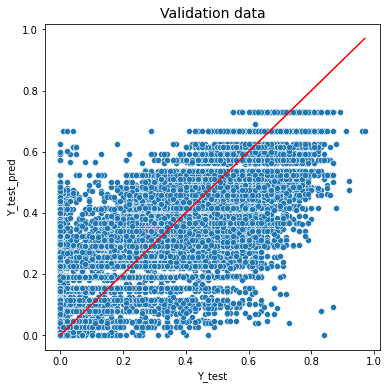

In [195]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('Validation data', fontsize=14)
plt.show()

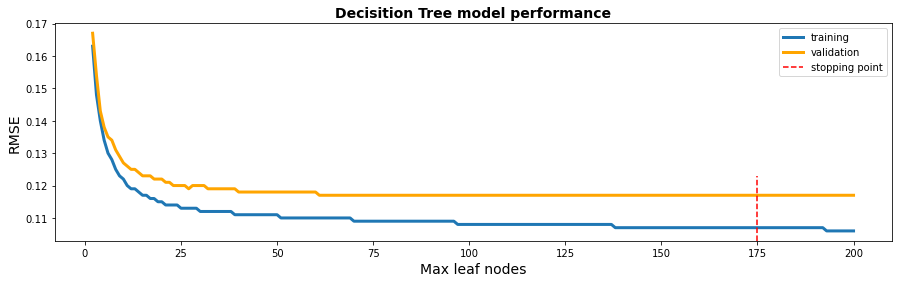

In [196]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(2, 201)
y_t = RMSE3_train
y_v = RMSE3_test

plt.plot(x, y_t, linestyle='solid', linewidth = 3,label = 'training')
plt.plot(x, y_v, color='orange', linestyle='solid', linewidth = 3, label = 'validation') 
plt.axvline(x=175, ymin=0, ymax=0.3, color='red',linestyle='dashed', label = 'stopping point')
plt.legend() 
# naming the x axis
plt.xlabel('Max leaf nodes', fontsize=14)
# naming the y axis
plt.ylabel('RMSE', fontsize=14)
  
# giving a title to my graph
plt.title('Decisition Tree model performance', fontsize=14, fontweight="bold")
plt.show()

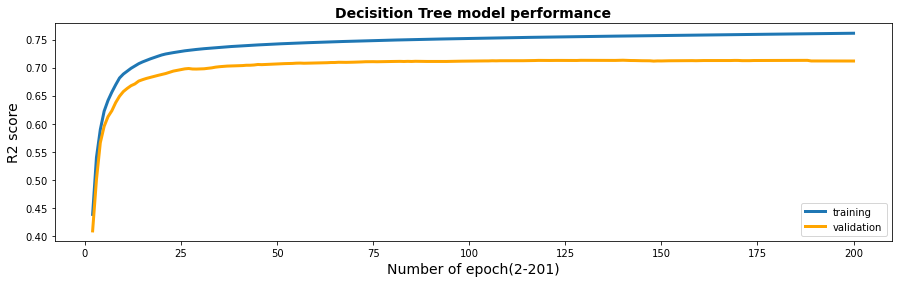

In [197]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(2, 201)
y_t = r2_train
y_v = r2_test

plt.plot(x, y_t, linestyle='solid', linewidth = 3,label = 'training')
plt.plot(x, y_v, color='orange', linestyle='solid', linewidth = 3, label = 'validation') 
#plt.axvline(x=176, ymin=0, ymax=0.3, color='red',linestyle='dashed', label = 'stopping point')
plt.legend() 
# naming the x axis
plt.xlabel('Number of epoch(2-201)', fontsize=14 )
# naming the y axis
plt.ylabel('R2 score', fontsize=14)
  
# giving a title to my graph
plt.title('Decisition Tree model performance',fontsize=14, fontweight="bold")
plt.show()

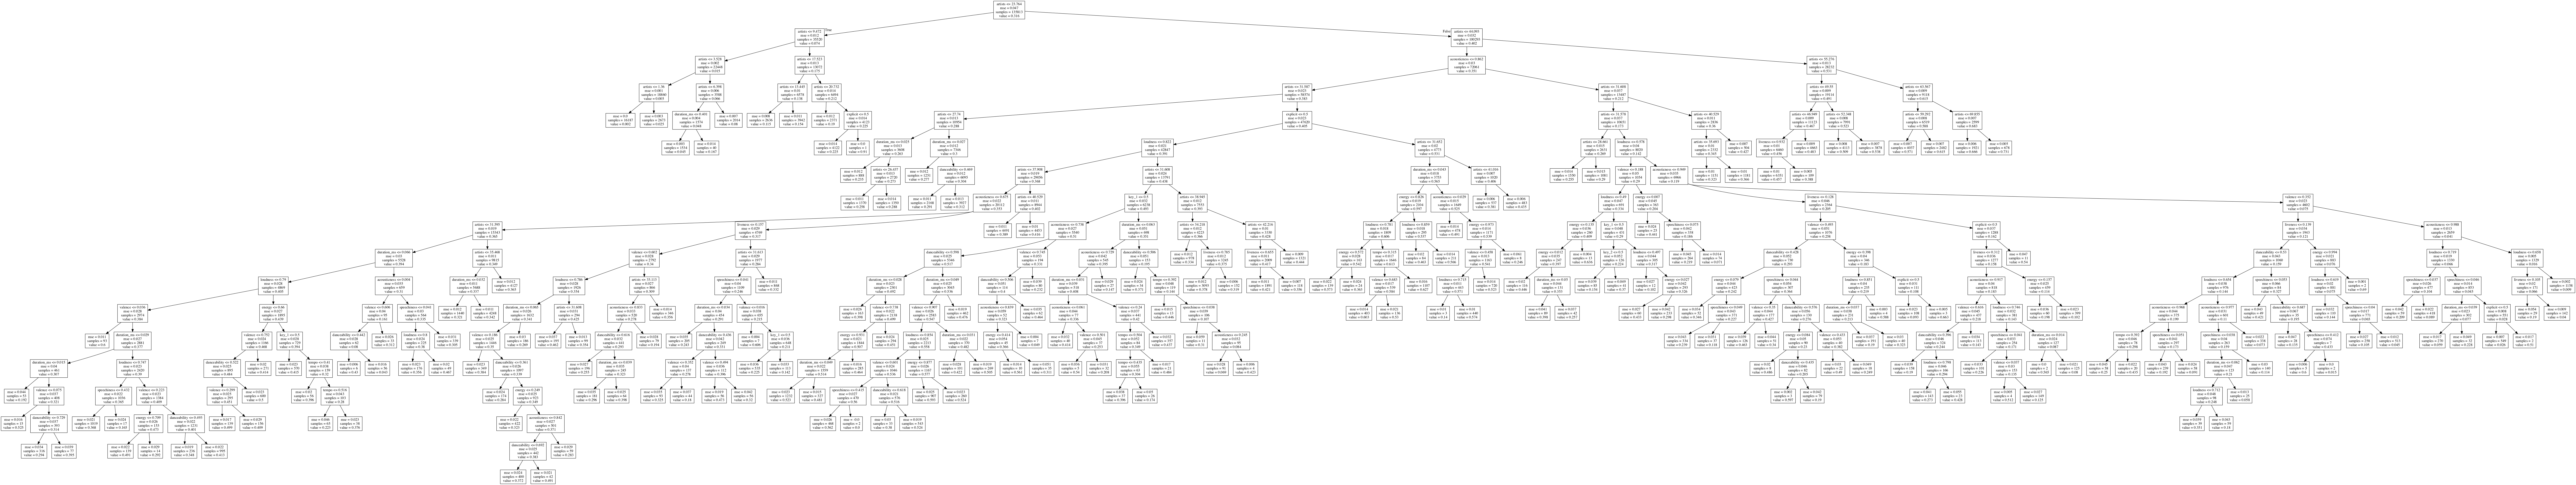

In [198]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [80]:

result = [(RMSE3_train[i]/RMSE3_test[i]) for i, num in enumerate(RMSE3_train)]

print(f'Minimum validiation is: {min(result):.3%} at epoch {result.index(min(result))}')
print(f'Maximum validiation is: {max(result):.3%} at epoch {result.index(max(result))}')

Minimum validiation is: 90.598% at epoch 191
Maximum validiation is: 97.902% at epoch 2


<h1>3) Random Forest Model</h1>

using PCA

In [292]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

r2_train_list = []
r2_test_list = []

RMSE_train, RMSE_test = [], []

for i in range(5, 100):
    
    if i % 10 == 0 :
        print(f"at {i}'th epoch")
        
    regressor_rf= Pipeline([('pca', PCA(n_components = 3)),
                            ('reg', RandomForestRegressor(n_estimators=i, random_state=42))])

    regressor_rf.fit(X_train,y_train)
    
    
    #y_pred_rf=regressor_rf.predict(X_test)
    #r2_list.append(r2_score(y_test, y_pred_rf))
    
#Training
    y_train_pred_rf = regressor_rf.predict(X_train)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
    r2_train = r2_score(y_train, y_train_pred_rf)
    
    RMSE_train.append(rmse_train)
    r2_train_list.append(r2_train)
    
#Validation    
    y_test_pred_rf = regressor_rf.predict(X_test)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
    r2_test = r2_score(y_test, y_test_pred_rf)
    
    RMSE_test.append(rmse_test)
    r2_test_list.append(r2_test)

at 10'th epoch
at 20'th epoch
at 30'th epoch
at 40'th epoch
at 50'th epoch
at 60'th epoch
at 70'th epoch
at 80'th epoch
at 90'th epoch


In [296]:
#print('Training RMSE', RMSE_train)
print('Training RMSE', RMSE_train[-1])
print('Training R2 score', r2_train_list[-1])

#print('Testing RMSE', RMSE_test)
print('Testing RMSE', RMSE_test[-1])
print('Testing R2 score', r2_test_list[-1])

Training RMSE 0.057290059445810754
Training R2 score 0.9307560134965616
Testing RMSE 0.12361238259935063
Testing R2 score 0.6771928012355823


In [199]:
print("Training Score of Random Forest Regressor is: {}\n".format(regressor_rf.score(X_train, y_train)))
#print("R2 Score of Random Forest Regressor is: {}\n".format(r2_score(y_test, y_train_pred_rf)))
print("Mean Squared Error of Random Forest Regressor is: {}\n".format(mean_squared_error(y_test, y_test_pred_rf)))
print("Mean Absolute Error of Random Forest Regressor is: {}\n".format(mean_absolute_error(y_test,y_test_pred_rf)))

Training Score of Random Forest Regressor is: 0.9183660435252577

Mean Squared Error of Random Forest Regressor is: 0.015299281595544159

Mean Absolute Error of Random Forest Regressor is: 0.087168637244609



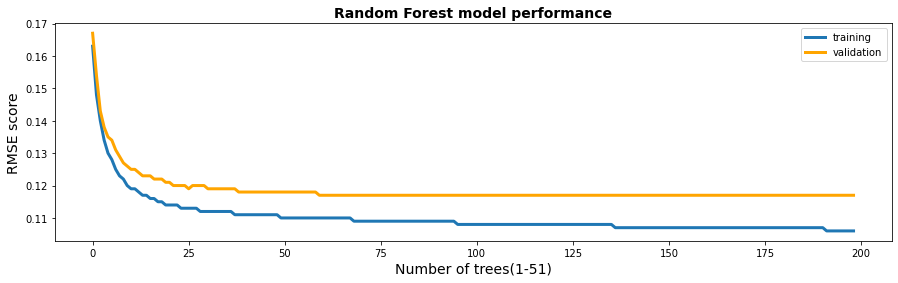

In [297]:
fig, ax = plt.subplots(figsize=(15,4))
#x = np.arange(5, 199)
y_t = RMSE3_train
y_v = RMSE3_test

plt.plot(y_t, linestyle='solid', linewidth = 3,label = 'training')
plt.plot(y_v, color='orange', linestyle='solid', linewidth = 3, label = 'validation') 

plt.legend() 
# naming the x axis
plt.xlabel('Number of trees(1-51)', fontsize=14)
# naming the y axis
plt.ylabel('RMSE score', fontsize=14)
  
# giving a title to my graph
plt.title('Random Forest model performance', fontsize=14, fontweight="bold" )
plt.show()

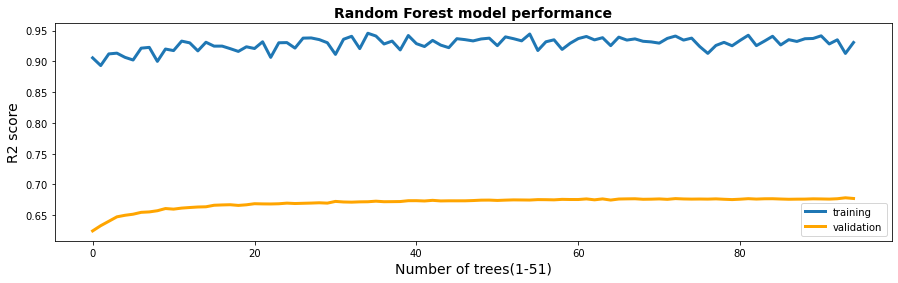

In [298]:
fig, ax = plt.subplots(figsize=(15,4))
#x = np.arange(5, 150)
y_t = r2_train_list
y_v = r2_test_list

plt.plot(y_t, linestyle='solid', linewidth = 3,label = 'training')
plt.plot(y_v, color='orange', linestyle='solid', linewidth = 3, label = 'validation') 
#plt.axvline(x=176, ymin=0, ymax=0.3, color='red',linestyle='dashed', label = 'stopping point')
plt.legend() 
# naming the x axis
plt.xlabel('Number of trees(1-51)', fontsize = 14)
# naming the y axis
plt.ylabel('R2 score', fontsize = 14)
  
# giving a title to my graph
plt.title('Random Forest model performance', fontsize = 14, fontweight="bold")
plt.show()

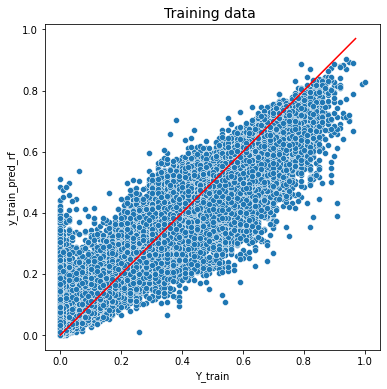

In [299]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred_rf)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('y_train_pred_rf')
ax.set_title('Training data ', fontsize=14)
plt.show()

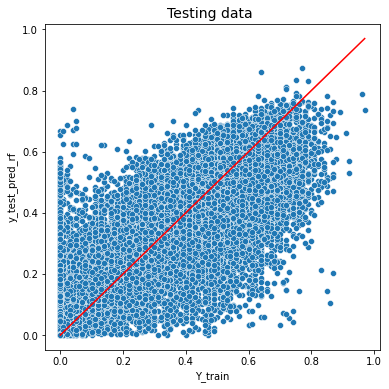

In [300]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred_rf)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('y_test_pred_rf')
ax.set_title('Testing data ', fontsize=14)
plt.show()

<h1>4) KNN Model</h1>

Due to long running time, we sampled the original data with frac = 0.3.

*5 to 100 neighbors*

In [329]:
RMSE1_train, RMSE1_test = [], []
r2_train, r2_test = [], []
  
for i in range(5,101,5):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    
    #training
    y_train_pred = knn.predict(X_train)
    knn_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_knn_train = r2_score(y_train, y_train_pred)
    r2_train.append(r2_knn_train)
    RMSE1_train.append(knn_train_rmse.round(3))
    
    #testing
    y_test_pred = knn.predict(X_test)
    knn_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_knn_test = r2_score(y_test, y_test_pred)
    r2_test.append(r2_knn_test)
    RMSE1_test.append(knn_test_rmse.round(3))

In [330]:
print(RMSE1_train[-1])
print(r2_train[-1])
print(RMSE1_test[-1])
print(r2_test[-1])

0.126
0.6658817437830151
0.135
0.6081371440790742


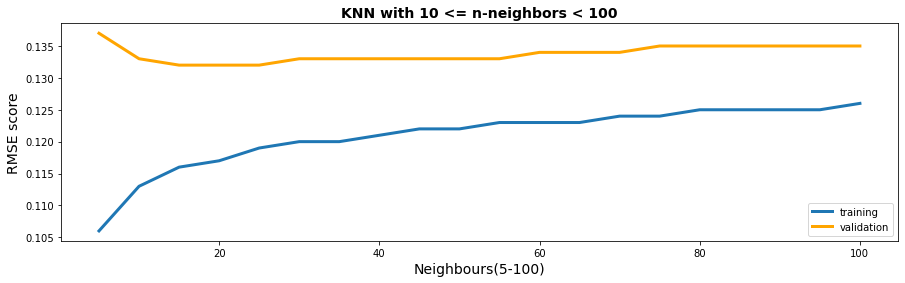

In [331]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(5, 101, 5)
y_t = RMSE1_train
y_v = RMSE1_test

plt.plot(x, y_t, linestyle='solid', linewidth = 3,label = 'training')
plt.plot(x, y_v, color='orange', linestyle='solid', linewidth = 3, label = 'validation') 

plt.legend() 
# naming the x axis
plt.xlabel('Neighbours(5-100)', fontsize=14)
# naming the y axis
plt.ylabel('RMSE score', fontsize=14)
  
# giving a title to my graph
plt.title('KNN with 10 <= n-neighbors < 100', fontsize=14, fontweight="bold" )
plt.show()

In [332]:
gap1 = [RMSE1_test[num]-RMSE1_train[num] for num, i in enumerate(RMSE1_train)]
min(gap1).round(3)

0.009

In [333]:
print(gap1.index(min(gap1)))
print(f'RMSE Train: {RMSE1_train[19]}, RMSE_test: {RMSE1_test[19]}')

19
RMSE Train: 0.126, RMSE_test: 0.135


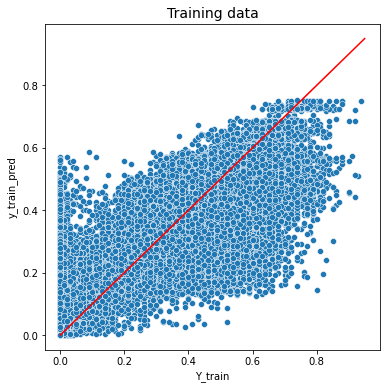

In [334]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_train, y=y_train_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_train')
ax.set_ylabel('y_train_pred')
ax.set_title('Training data', fontsize=14)
plt.show()

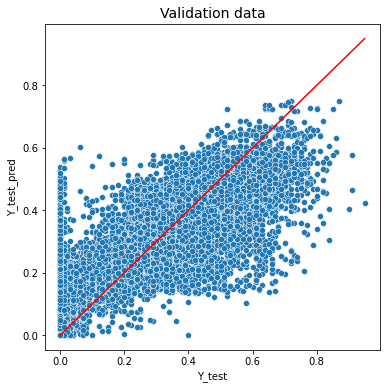

In [335]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('Validation data', fontsize=14)
plt.show()

*Since the r2 score and RMSE values are very close for Random regressor and decision tree regressor, so considering the running time taken by the model, decision tree seems to be an optimal choice for this dataset.*

In [378]:
print('Feature importance for deciding the popularity of a song\n')
for i, col in enumerate(X_train.columns):
    print(f'{col:15}: {tree.feature_importances_[i]:.3f}')

Feature importance for deciding the popularity of a song

valence        : 0.007
acousticness   : 0.076
artists        : 0.856
danceability   : 0.004
duration_ms    : 0.006
energy         : 0.003
explicit       : 0.018
liveness       : 0.003
loudness       : 0.019
mode           : 0.000
speechiness    : 0.003
tempo          : 0.001
key_1          : 0.004
key_2          : 0.000
key_3          : 0.000
key_4          : 0.000
key_5          : 0.000
key_6          : 0.000
key_7          : 0.000
key_8          : 0.000
key_9          : 0.000
key_10         : 0.000
key_11         : 0.000
ins_2          : 0.000
ins_3          : 0.000


<h1>Conclusion</h1>

1) We explored the spotify dataset, dropped unnecessary features, and tested different regression models: Linear Regression, Decision Tree Regression, Random Forest regression & KNN regression model.

2) We also tested the data with different test size and random state number in order to check the influence on the results.

3) Eventually, the best model was a Decision Tree run with test size = 0.2, random state = 42.

4) This gave a training R2 score = 0.7613, testing R2 score = 0.711,  RMSE of training = 0.106 & RMSE of testing  = 0.1167.

5) 'Artist' feature has major impact on deciding the popularity of the song.